# Introduction

In this notebook, we decided to work on Sign Language Recogntion using Graph Convolutional Network(GCN).



Our approach was Pose-based Temporal GCN which was previously published by [Dongxu Li](https://github.com/dxli94/WLASL).

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-processing

In [ ]:
import os
import json

# Load the WLASL dataset metadata from the JSON file
with open('/content/drive/MyDrive/WLASL/start_kit/WLASL_v0.3.json') as f:
    metadata = json.load(f)

# Create a dictionary to map label names to label IDs and vice versa
label_dict = {label['gloss']: i for i, label in enumerate(metadata)}
label_names = {i: label['gloss'] for i, label in enumerate(metadata)}

In [ ]:
label_videos = {}

for label in metadata:
    gloss = label['gloss']
    video_ids = [instance['video_id'] for instance in label['instances']]
    label_videos[gloss] = video_ids

In [ ]:
for gloss, video_ids in label_videos.items():
    print(f'{gloss}: {video_ids}')

book: ['69241', '65225', '68011', '68208', '68012', '70212', '70266', '07085', '07086', '07087', '07069', '07088', '07089', '07090', '07091', '07092', '07093', '07068', '07094', '07095', '07096', '07097', '07070', '07098', '07099', '07071', '07072', '07073', '67424', '07074', '07075', '07076', '07077', '07078', '07079', '07080', '07081', '07082', '07083', '07084']
drink: ['69302', '65539', '70173', '68538', '68042', '68660', '68041', '17725', '17726', '17727', '17728', '17710', '17729', '17730', '17731', '17732', '17733', '65540', '17734', '17711', '17712', '17713', '17714', '17715', '17716', '17717', '17718', '17709', '67594', '17719', '17720', '17721', '17722', '17723', '17724']
computer: ['12306', '68028', '69054', '12328', '12329', '12330', '12312', '12331', '12332', '12333', '12335', '12336', '12311', '12337', '12338', '12313', '12314', '12315', '12316', '12317', '12318', '12319', '12320', '67519', '12321', '12322', '12323', '12324', '12326', '12327']
before: ['05724', '70348', '6

# Data Loading

In [2]:
import cv2
import os
import numpy as np

def load_video_frames(video_path):
    """
    Load the frames of a video file into a list of NumPy arrays.

    Args:
        video_path (str): Path to the video file.

    Returns:
        frames (list): List of NumPy arrays representing the frames of the video.
    """
    # Check if the video file exists
    if not os.path.isfile(video_path):
        raise ValueError(f"{video_path} is not a valid file path.")

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Read the frames of the video and store them in a list
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB format
        frames.append(frame)

    # Release the video file
    cap.release()

    # Convert the list of frames to a NumPy array
    frames = np.array(frames)

    return frames

In [3]:
import numpy as np

def create_adjacency_matrix(frames):
    num_frames = len(frames)
    frame_shape = frames[0].shape[:2]
    edges = []

    # Find adjacent frames based on pixel differences
    for i in range(num_frames):
        for j in range(i+1, num_frames):
            frame_diff = np.abs(frames[i] - frames[j])
            pixel_diff = np.sum(frame_diff) / (frame_shape[0] * frame_shape[1])
            if pixel_diff < 20: # threshold for adjacent frames
                edges.append((i, j))

    # Create empty adjacency matrix
    adj_matrix = np.zeros((num_frames, num_frames))

    # Add edges to adjacency matrix
    for u, v in edges:
        adj_matrix[u][v] = 1
        adj_matrix[v][u] = 1

    return adj_matrix

In [4]:
import torch

def save_output(output, file_path):
    """
    Saves PyTorch model output to a file.

    Args:
        output (torch.Tensor): The output tensor to save.
        file_path (str): The path to the file to save to.
    """
    with open(file_path, 'w') as f:
        for row in output:
            f.write('\t'.join([str(x) for x in row.tolist()]) + '\n')

In [5]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=c136126defb4848f3db82440c33583d326554ecda0c9cecf5a28021b351c90d3
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [6]:
!pip install av
import torch
import numpy as np
import av
from torch_geometric.data import Data

def preprocess_video(video_id):
    # Open video file using PyAV
    container = av.open('/content/drive/MyDrive/WLASL/start_kit/raw_videos/{}.mp4'.format(video_id))

    # Load video frames
    frames = []
    for frame in container.decode(video=0):
        frames.append(frame.to_rgb().to_ndarray())
    fps = container.streams.video[0].average_rate
    height = container.streams.video[0].height
    width = container.streams.video[0].width
    frames = np.stack(frames)

    # Create graph structure
    num_frames = frames.shape[0]
    adj_matrix = np.zeros((num_frames, num_frames), dtype=np.float32)
    for i in range(num_frames):
        for j in range(i+1, num_frames):
            diff = np.abs(frames[i] - frames[j])
            sim = np.exp(-np.sum(diff**2) / (height*width))
            adj_matrix[i, j] = sim
            adj_matrix[j, i] = sim

    deg = np.sum(adj_matrix, axis=1)
    deg_inv_sqrt = 1 / np.sqrt(deg)
    deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0

    # Convert adjacency matrix to edge index format
    edge_index = torch.LongTensor(np.transpose(np.nonzero(adj_matrix)))
    edge_weight = torch.FloatTensor(deg_inv_sqrt[edge_index[:,0]] * adj_matrix[tuple(edge_index.T)] * deg_inv_sqrt[edge_index[:,1]])

    # Create node feature matrix
    x = torch.from_numpy(frames.transpose(0, 3, 1, 2)).to(torch.float32)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_weight)

    return data,adj_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 23.2 MB/s eta 0:00:00


# Temporal Graph Convolutional Network (TGCN)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import ChebConv
from torch_geometric.data import Data

class TGCN(nn.Module):
    def __init__(self, in_channels, out_channels, K):
        super(TGCN, self).__init__()
        self.conv1 = ChebConv(in_channels, out_channels, K)
        self.conv2 = ChebConv(out_channels, out_channels, K)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.fc(x)
        return torch.sigmoid(x)

# Graph Visualization

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_vis(video_id):
    # Load video frames
    frames = load_video_frames('/content/drive/MyDrive/WLASL/start_kit/raw_videos/{}.mp4'.format(video_id))

    # Create graph structure
    adj_matrix = create_adjacency_matrix(frames)

    # Convert adjacency matrix to edge index format
    edge_index = torch.tensor(np.nonzero(adj_matrix), dtype=torch.long)

    # Create node feature matrix
    x = torch.tensor(frames, dtype=torch.float)

    # Create batch vector
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    # Define model
    model = TGCN(in_channels=3, out_channels=16, K=2)

    # Forward pass
    data = Data(x=x, edge_index=edge_index)
    gra_ph = model(data)

    # Visualize the graph
    graph = nx.Graph()
    num_nodes = frames.shape[0]
    graph.add_nodes_from(range(num_nodes))
    edges = edge_index.numpy().T
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True)
    plt.show()

    return gra_ph

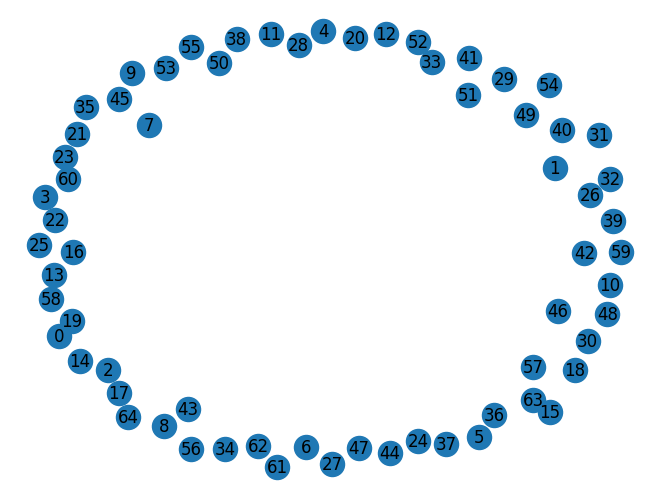

tensor([[[1.0000],
         [1.0000],
         [1.0000],
         ...,
         [0.9996],
         [0.9996],
         [0.9995]],

        [[1.0000],
         [1.0000],
         [1.0000],
         ...,
         [0.9996],
         [0.9996],
         [0.9995]],

        [[1.0000],
         [1.0000],
         [1.0000],
         ...,
         [0.9996],
         [0.9996],
         [0.9995]],

        ...,

        [[1.0000],
         [1.0000],
         [1.0000],
         ...,
         [0.9995],
         [0.9995],
         [0.9995]],

        [[1.0000],
         [1.0000],
         [1.0000],
         ...,
         [0.9995],
         [0.9995],
         [0.9995]],

        [[0.4932],
         [0.4932],
         [0.4932],
         ...,
         [0.4932],
         [0.4932],
         [0.4932]]], grad_fn=<SigmoidBackward0>)

In [11]:
graph_vis("00336")

# Conclusion:
Sadly, this is an end to our experiment about implementing TGCN on simple hardware. We've tried to load the entire WLASL dataset but to it's huge size it wasn't an efficient approach so we thought of implementing same on the subsets.

Much to our grief, being only a part of our mini project we weren't able to invest resources in this project, so our conclusion:
## Why TGCN failed?

TGCN (Temporal Graph Convolutional Networks) is currently facing challenges due to
runtime errors and high computational demands. The integration of heavy modules
like cv2 (OpenCV) and others contributes to an increased overall weight, resulting in
frequent runtime errors that hinder its smooth execution. Furthermore, TGCN’s high
computational requirements make it resource-intensive and lead to significant RAM usage.